In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

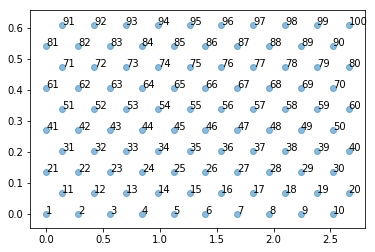

In [2]:
# N must be even and this will make a lattice with N points in x and N points in y directions

N = 10
d = 0.28

# set up square mesh

nx, ny = (N, N)
x = np.linspace(0, N-1, nx)*d
y = np.linspace(0, N-1, ny)*d
xv, yv = np.meshgrid(x, y)
xv_array = np.asarray(xv).reshape(-1)
yv_array = np.asarray(yv).reshape(-1)

# scaling for hexagonal points (in y)
y_scale = np.sqrt(3)/2*d
yv_hex = yv_array*y_scale

# shift for hexagonal points (in x) - for every second row, bump a bit to the right
no_shift = np.zeros((N))
yes_shift = np.ones((N))*d/2

# vector that contains shifts for x coordinate every second row in lattice
x_shift = np.concatenate((no_shift, yes_shift), axis=0)

xv_hex = xv_array + np.tile(x_shift, N//2)

coordinates_hex = np.vstack((xv_hex, yv_hex))

plt.scatter(coordinates_hex[0,:],coordinates_hex[1,:], alpha = 0.5)

for i in range(N**2):
    plt.text(coordinates_hex[0,i],coordinates_hex[1,i], str(i+1))

plt.show()

In [3]:
def neighbour(a):
    '''return neigbouring sites of a lattice position'''   
    x_even = np.linspace(0.5, N-0.5, nx)*d
    x_even = np.around(x_even, 2)
    x_odd = np.around(x, 2)
    sites = np.array([])
    
    def corners(a):
        '''checks if position is located at one of the corners'''
        c_sites = np.array([])
        if coordinates_hex[0,a] == 0.0 and coordinates_hex[1,a] == 0.0:
            c_sites = np.append(c_sites, [a+N-1, a+2*N-1, a+N, a+1, N**2-(N-a), N**2-1])
        if coordinates_hex[0,a] == d*(N-1) and coordinates_hex[1,a] == 0.0:
            c_sites = np.append(c_sites, [a-1, a+N-1, a+N, a-N+1, N**2-1,  (N**2-1)-(N-a)])
        if coordinates_hex[0,a] == d/2 and coordinates_hex[1,a] == y_scale*d*(N-1):
            c_sites = np.append(c_sites, [a+N-1, N-(N**2-a), N-(N**2-a)+1, a+1, a-N+1,  a-N])
        if coordinates_hex[0,a] == d/2 + (N-1)*d and coordinates_hex[1,a] == y_scale*d*(N-1):
            c_sites = np.append(c_sites, [a-1, N-(N**2-a), 1, a-N+1, a-2*N+1, a-N])
        return c_sites
    
    def flcol(a):
        '''checks if position is located at the vertical sides'''
        value = round(xv_hex[a], 2)
        s_sites = np.array([])
        if a%N == 0:
            if value in x_odd: 
                s_sites = np.append(s_sites, [a+N-1, a+2*N-1, a+N, a+1, a-N, a-1])
            elif value in x_even:   
                s_sites = np.append(s_sites, [a+N-1, a+N, a+N+1, a+1, a-N+1, a-N])
        if (a+1)%N == 0:
            if value in x_odd:
                s_sites = np.append(s_sites, [a-1, a+N-1, a+N, a-N+1, a-N, a-N-1])
            elif value in x_even:
                s_sites = np.append(s_sites, [a-1, a+N, a+1, a-N+1, a-2*N+1, a-N])
        return s_sites
     
    def flrow(a):
        '''checks if position is located at the horizontal sides'''
        r_sites = np.array([])
        if a in np.arange(0,N):
            r_sites = np.append(r_sites, [a-1, a+N-1, a+N, a+1, N**2-(N-a), N**2-(N-a)-1])
        if a in np.arange(N**2-N, N**2):
            r_sites = np.append(r_sites, [a-1, N-(N**2-a), N-(N**2-a)+1, a+1, a-N+1, a-N])
        return r_sites
    
    def mid(a):
        '''checks if position is on "odd" row or "even" row'''
        value = round(xv_hex[a], 2)
        m_sites = np.array([])
        if value in x_odd:
            m_sites = np.append(m_sites, [a-1, a+N-1, a+N, a+1, a-N, a-N-1])
        if value in x_even:
            m_sites = np.append(m_sites, [a-1, a+N, a+N+1, a+1, a-N+1, a-N])
        return m_sites
    
    if len(corners(a))!= 0:
        sites = np.append(sites, corners(a))
        return sites
    elif len(flcol(a))!= 0:
        sites = np.append(sites, flcol(a))
        return sites
    elif len(flrow(a))!= 0:
        sites = np.append(sites, flrow(a))
        return sites
    else:
        sites = np.append(sites, mid(a))
        return sites

In [21]:
class Simulation:
    
    def __init__(self, E_act, noise, temp, start_pos):
        # activation energy
        self.active = E_act
        # noise in system
        self.disorder = noise
        # initiation point
        self.start = 31
        
        # angle between points and effect on external field
        angle = 60/180*np.pi
        self.field = np.array([1, np.cos(angle), -np.cos(angle), -1, -np.cos(angle), np.cos(angle)])
        self.xdist = np.array([-d, -d/2, d/2, d, d/2, -d/2])
        self.ydist = np.array([0, np.sqrt(3)/2*d, np.sqrt(3)/2*d, 0, -np.sqrt(3)/2*d, -np.sqrt(3)/2*d])
        kB = 8.617332e-5
        self.kT = kB * temp
        
        #track position
        self.hops = []

    
    def factor(self):
        '''returns pre-exponential factor for hopping rate '''
        return 2 * self.kT / 4.1357e-15
    
    def kmc(self):
        '''returns mean squared total displacement at set time intervals '''
        E = np.random.uniform(-0.1, 0.1, (N**2))
        # choosing a random lattice point in the centre of lattice
        #a = np.random.randint(2*N,N**2-2*N)
        a = self.start
        # construct table
        df = pd.DataFrame([])
        
        indexing = np.array([])
        time = 0 
        
        # keep tracks of time
        x_time = np.array([])
        # record mean squared displacement
        track_pos = np.array([])
        
        # simulation runs until number of hops is reached
        for i in range(100):
            
            if self.disorder != 0:
                dE = np.array([])
                # retrieve neigbouring points from neigbour function
                for i in neighbour(a):
                    i = i.astype(int)
                    # adds noise to activation energy
                    dE = np.append(dE, E[i]*self.disorder + self.active)
            else:
                # condition when no noise is introduced to the system
                dE = np.ones(5)*self.active
                
            # can include electric field if needed 
            E_tot = dE
            # rate of hopping
            v = self.factor()*np.exp(-E_tot/self.kT)
            # generate random number
            Randnum1 = random.uniform(0,1) 
            # set position of pointer
            rk = Randnum1 * np.sum(v)
            # cumulative sum of energy
            k = np.cumsum(v)
            
            # going through k1, k1+k2...., ktotal
            for i in np.nditer(k):
            # if value smaller than pointer choose path
                if i > rk:
                    next_step = list(k).index(i)
                    break
            indexing = np.append(indexing, next_step)
            # generate second random number
            Randnum2 = random.uniform(0,1)
            # increment time for each step
            time = time +(-1/np.sum(v)) * np.log(Randnum2)
            # update a for new lattice site
            a = (neighbour(a)[next_step]).astype(int)
            
            # for every time increment, output time and mean square displacement
            x_time = np.append(x_time, time)
            track_pos = np.append(track_pos, a)
        return x_time, track_pos, indexing
    
    
        

In [22]:
run = Simulation(0.6, 0, 298, 31)
time, position, index = run.kmc()
print(position)


[32. 42. 43. 42. 52. 62. 71. 72. 83. 92. 91. 90. 91.  1. 10. 20. 29. 20.
 10. 11. 21. 31. 30. 39. 30. 40. 49. 40. 50. 59. 60. 70. 71. 62. 71. 70.
 80. 70. 61. 60. 79. 60. 69. 60. 61. 51. 50. 61. 60. 50. 59. 69. 79. 78.
 89. 88. 87. 96.  7. 17.  8. 18.  9. 99. 90. 99. 90.  1. 10. 19. 29. 20.
 30. 40. 49. 39. 49. 59. 58. 59. 40. 49. 39. 49. 48. 47. 37. 28. 27. 36.
 47. 46. 36. 37. 47. 57. 56. 67. 57. 58.]


In [8]:
sim_time = np.array([])
m = 1
while m < len(time)-1:
    for k in range(m+1, len(time)):
        time_diff = time[k] - time[m]
        sim_time = np.append(sim_time, time_diff)
    m += 1
print(sim_time)

[1.10207404e-04 1.98407252e-04 3.10107329e-04 5.74832204e-04
 8.75929702e-04 9.77315762e-04 1.36267348e-03 1.68154320e-03
 8.81998477e-05 1.99899924e-04 4.64624800e-04 7.65722298e-04
 8.67108358e-04 1.25246607e-03 1.57133579e-03 1.11700077e-04
 3.76424952e-04 6.77522450e-04 7.78908510e-04 1.16426623e-03
 1.48313595e-03 2.64724875e-04 5.65822373e-04 6.67208433e-04
 1.05256615e-03 1.37143587e-03 3.01097498e-04 4.02483558e-04
 7.87841273e-04 1.10671099e-03 1.01386060e-04 4.86743775e-04
 8.05613496e-04 3.85357715e-04 7.04227436e-04 3.18869721e-04]


In [9]:
x_pos = np.array([])
y_pos = np.array([])
for i in range(len(time)):
    x_pos = np.append(x_pos, coordinates_hex[0,int(position[i])])
    y_pos = np.append(y_pos, coordinates_hex[1,int(position[i])])
print(x_pos)
print(y_pos)

[0.7  0.84 1.12 0.98 1.26 1.12 1.26 1.54 1.82 1.96]
[0.61106752 0.54317113 0.54317113 0.61106752 0.61106752 0.
 0.61106752 0.61106752 0.61106752 0.54317113]


In [ ]:
x_even = np.linspace(0.5, N-0.5, nx)*d
x_even = np.around(x_even, 2)
x_odd = np.around(x, 2)


In [18]:
last_index = len(position)-1
# top edge row
j = np.where(position > N**2-N)
j = np.array(j).tolist()[0]

if last_index in j:
    j.remove(last_index)
j = np.array(j)
print(j)
for r in np.nditer(j):
    if index[r+1] == 1:
        x_pos[r+1] = x_pos[r] - d/2
        y_pos[r+1] = y_pos[r] + np.sqrt(3)/2*d
        print('done')
    if index[r+1] == 2:
        x_pos[r+1] = x_pos[r] + d/2
        y_pos[r+1] = y_pos[r] + np.sqrt(3)/2*d

print(x_pos)



[0 3 4 6 7 8]
done
[0.7  0.84 1.12 0.98 1.26 1.12 1.26 1.54 1.82 1.96]


In [15]:
last_index = len(position)-1
# bottom edge row
k = np.where(position < N)
k = np.array(k).tolist()[0]
if last_index in k:
    k.remove(last_index)
k = np.array(k)
print(k)

for r in np.nditer(k):
    if index[r+1] == 4:
        x_pos[r+1] = x_pos[r] + d/2
        y_pos[r+1] = y_pos[r] - np.sqrt(3)/2*d
    if index[r+1] == 5:
        x_pos[r+1] = x_pos[r] - d/2
        y_pos[r+1] = y_pos[r] - np.sqrt(3)/2*d
print(x_pos)

[5]
[0.7  0.84 1.12 0.98 1.26 1.12 1.26 1.54 1.82 1.96]


In [29]:
dis = np.array([])
n = 0
while n < len(time):
    for p in range(n+1, len(time)):
        x_diff = coordinates_hex[0,int(position[p])] - coordinates_hex[0,int(position[n])]
        y_diff = coordinates_hex[1,int(position[p])] - coordinates_hex[1,int(position[n])]
        displacement = np.sqrt(x_diff**2+y_diff**2)
        dis = np.append(dis, displacement)
    n += 1
print(dis)

[0.15559537 0.15559537 0.15559537 0.42545261 0.57622884 0.31119075
 0.24716246 0.46678612 0.39007527 0.28       0.         0.28
 0.42545261 0.15559537 0.13579278 0.31119075 0.24716246 0.28
 0.56       0.70328509 0.42545261 0.31119075 0.57622884 0.46678612
 0.28       0.42545261 0.15559537 0.13579278 0.31119075 0.24716246
 0.15559537 0.15559537 0.31119075 0.13579278 0.24716246 0.28
 0.42545261 0.15559537 0.31119075 0.15559537 0.15559537 0.13579278
 0.28       0.15559537 0.15559537]


In [6]:
n_times = np.array(range(10, 2000, 50))
df_mean = np.array([])
df_err = np.array([])
for r in np.nditer(n_times):
    col_df = np.array([])
    col_var = np.array([])
    for n in range(r):
        run = Simulation(0.6, 1, 298, 31)
        data = run.kmc()
        result = Calc(data['time,s'], data['MSD,nm^2'])
        df = result.diff_coeff()
        col_df = np.append(col_df, df)
        variance = result.var()
        col_var = np.append(col_var, variance)
        rec_var = 1/col_var
    w_mean = np.sum(np.multiply(col_df, rec_var))/np.sum(rec_var)
    std_err = np.sqrt(1/np.sum(rec_var))
    df_mean = np.append(df_mean, w_mean)
    df_err = np.append(df_err, std_err)

   